Possible setup:

**Install**
```sh
setupATLAS
asetup AnalysisBase,22.2.74
export PYTHONNOUSERSITE=1 # we want to put all extra packages into a virtualenv (ignore user site packages)
# --system-site-packages will help to only install what is not yet in the ATLAS environment
python -m venv --system-site-packages .extra-packages-AnalysisBase-22.2.74
source .extra-packages-AnalysisBase-22.2.74/bin/activate
# since the ATLAS setup uses PYTHONPATH we also put the extra-packages dir in front
# to prioritize packages from there if nescessary
export PYTHONPATH=$(pwd)/.extra-packages-AnalysisBase-22.2.74/lib/python3.9/site-packages:$PYTHONPATH
# now install extra packages
pip install jupyterlab awkward vector matplotlib
```

**Setup next time**
```sh
setupATLAS
asetup AnalysisBase,22.2.74
export PYTHONNOUSERSITE=1
source .extra-packages-AnalysisBase-22.2.74/bin/activate
export PYTHONPATH=$(pwd)/.extra-packages-AnalysisBase-22.2.74/lib/python3.9/site-packages:$PYTHONPATH
```

**Run with**
```sh
jupyter lab
```

In [1]:
import ROOT
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/06


following Attila's presentation https://indico.cern.ch/event/1140386/

Also see https://gitlab.cern.ch/akraszna/xAODDataSource/-/tree/master/xAODDataFrameTests/util

In [2]:
ROOT.xAOD.Init().ignore()
#ROOT.ROOT.EnableImplicitMT() # haven't gotting this working yet with decorators
from xAODDataSource.Helpers import MakexAODDataFrame

# instantiate needed container types
ROOT.xAOD.ElectronContainer()

<cppyy.gbl.DataVector<xAOD::Electron_v1> object at 0x1bd0d760>

xAOD::Init                INFO    Environment initialised for data access


In [3]:
filename = "user.nihartma.22884623.EXT0._000001.DAOD_PHYSLITE.test.pool.root"
rdf = MakexAODDataFrame(filename)

In [4]:
list(rdf.GetColumnNames())

['AnalysisElectrons',
 'AnalysisHLT_2e12_lhloose_nod0_mu10',
 'AnalysisHLT_2e12_lhloose_nodeta_L12EM10VH',
 'AnalysisHLT_2e12_lhloose_nodphires_L12EM10VH',
 'AnalysisHLT_2e17_lhvloose_nod0',
 'AnalysisHLT_2e17_lhvloose_nod0_L12EM15VHI',
 'AnalysisHLT_2e17_lhvloose_nod0_ringer',
 'AnalysisHLT_2e17_lhvloose_nod0_ringer_L12EM15VHI',
 'AnalysisHLT_2e24_lhvloose_nod0',
 'AnalysisHLT_2g20_loose_g15_loose',
 'AnalysisHLT_2g20_tight',
 'AnalysisHLT_2g20_tight_icalovloose_L12EM15VHI',
 'AnalysisHLT_2g22_tight',
 'AnalysisHLT_2g22_tight_L12EM15VHI',
 'AnalysisHLT_2g22_tight_L1EM7_EMPTY',
 'AnalysisHLT_2g22_tight_L1EM7_UNPAIRED_ISO',
 'AnalysisHLT_2g22_tight_icalovloose',
 'AnalysisHLT_2g25_loose_g15_loose',
 'AnalysisHLT_2g25_tight_L12EM20VH',
 'AnalysisHLT_2g50_loose_L12EM20VH',
 'AnalysisHLT_2mu10',
 'AnalysisHLT_2mu10_nomucomb',
 'AnalysisHLT_2mu14',
 'AnalysisHLT_2mu14_nomucomb',
 'AnalysisHLT_2mu20_L12MU20_OVERLAY',
 'AnalysisHLT_2mu4_mu3_mu2noL1_L13MU4',
 'AnalysisHLT_2mu4_mu3_mu2noL1_calo

In [5]:
rdf.GetColumnType("AnalysisElectrons")

'DataVector<xAOD::Electron_v1>'

In [6]:
rdf2 = rdf.Define("el_pt_0", "AnalysisElectrons.size() > 0 ? AnalysisElectrons[0]->pt() : -999")

In [7]:
rdf2.AsNumpy(["el_pt_0"])

{'el_pt_0': ndarray([  -999.        ,   3373.38525391,  67384.453125  , ...,
          100287.59375   ,  25825.640625  ,   6266.61523438])}

input_line_455:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<double>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [8]:
rdf2 = rdf.Define("el_pt_0", "AnalysisElectrons.size() > 0 ? AnalysisElectrons[0]->trackParticle()->pt() : -999")
rdf2.AsNumpy(["el_pt_0"])

{'el_pt_0': ndarray([ -999.        ,  4129.17535388, 32111.68112368, ...,
          91299.6962074 ,  2382.70603923,  5681.07067736])}

In [9]:
rdf3 = rdf.Define("el_track_pt", """
std::vector<float> pt;
for (auto electron: AnalysisElectrons) {
  pt.push_back(electron->trackParticle()->pt());
}
return pt;
""")

In [10]:
rdf3.GetColumnType("el_track_pt")

'vector<float>'

In [11]:
ak_pt = ak.Array(rdf3.Take[rdf3.GetColumnType("el_track_pt")]("el_track_pt"))

In [12]:
ak_pt.tolist()

[[],
 [4129.17529296875],
 [32111.681640625],
 [],
 [76299.625],
 [5160.49609375],
 [],
 [],
 [],
 [10969.140625],
 [],
 [],
 [6364.3095703125],
 [71289.875],
 [8686.5576171875],
 [94953.15625],
 [],
 [],
 [],
 [],
 [33015.515625, 23664.388671875],
 [47124.37109375],
 [],
 [],
 [70787.890625],
 [],
 [],
 [],
 [],
 [],
 [18758.6015625, 9385.89453125, 6837.953125],
 [79037.640625, 5989.1298828125],
 [],
 [26938.291015625],
 [29245.1953125],
 [],
 [],
 [],
 [],
 [],
 [12088.44140625],
 [],
 [],
 [],
 [],
 [37599.49609375],
 [],
 [],
 [29647.45703125],
 [4899.966796875],
 [],
 [80284.703125],
 [4333.9716796875],
 [18373.408203125],
 [],
 [],
 [22803.5859375],
 [37400.09765625],
 [120827.4765625],
 [],
 [58678.796875],
 [54082.515625],
 [],
 [],
 [3329.470458984375],
 [],
 [43364.57421875],
 [],
 [],
 [],
 [12183.97265625],
 [38545.73828125],
 [12990.7578125, 3536.606689453125],
 [],
 [],
 [],
 [50408.08203125],
 [],
 [7429.40380859375, 4134.0234375],
 [],
 [],
 [59857.44140625, 27735.8125]

In [13]:
%%cpp -d
template <typename T>
std::pair<std::vector<int64_t>, std::vector<T>>
flatten(std::vector<std::vector<T>> vv) {
  std::vector<int64_t> offsets;
  std::vector<T> content;
  offsets.reserve(1024);
  content.reserve(1024);
  int i = 0;
  for (auto v : vv) {
    offsets.push_back(i);
    for (auto x : v) {
      content.push_back(x);
      i++;
    }
  }
  offsets.push_back(i);
  return std::make_pair(offsets, content);
}

In [14]:
vv = rdf3.Take[rdf3.GetColumnType("el_track_pt")]("el_track_pt")

In [15]:
offsets, content = ROOT.flatten["float"](vv.GetValue())

In [16]:
print(list(content))

[4129.17529296875, 32111.681640625, 76299.625, 5160.49609375, 10969.140625, 6364.3095703125, 71289.875, 8686.5576171875, 94953.15625, 33015.515625, 23664.388671875, 47124.37109375, 70787.890625, 18758.6015625, 9385.89453125, 6837.953125, 79037.640625, 5989.1298828125, 26938.291015625, 29245.1953125, 12088.44140625, 37599.49609375, 29647.45703125, 4899.966796875, 80284.703125, 4333.9716796875, 18373.408203125, 22803.5859375, 37400.09765625, 120827.4765625, 58678.796875, 54082.515625, 3329.470458984375, 43364.57421875, 12183.97265625, 38545.73828125, 12990.7578125, 3536.606689453125, 50408.08203125, 7429.40380859375, 4134.0234375, 59857.44140625, 27735.8125, 19114.2578125, 47825.53125, 175156.03125, 150192.78125, 11827.7939453125, 45588.4375, 10110.0244140625, 7595.75146484375, 4195.14501953125, 75417.0703125, 74864.7890625, 41344.63671875, 10239.287109375, 29027.576171875, 73343.8828125, 51501.13671875, 13869.5234375, 5007.015625, 47071.16796875, 48343.6875, 33258.3359375, 44736.125, 41

In [17]:
print(list(offsets))

[0, 0, 1, 2, 2, 3, 4, 4, 4, 4, 5, 5, 5, 6, 7, 8, 9, 9, 9, 9, 9, 11, 12, 12, 12, 13, 13, 13, 13, 13, 13, 16, 18, 18, 19, 20, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 23, 24, 24, 25, 26, 27, 27, 27, 28, 29, 30, 30, 31, 32, 32, 32, 33, 33, 34, 34, 34, 34, 35, 36, 38, 38, 38, 38, 39, 39, 41, 41, 41, 43, 44, 44, 44, 44, 44, 44, 45, 46, 46, 46, 46, 46, 46, 47, 47, 48, 49, 49, 49, 50, 51, 52, 52, 52, 52, 52, 52, 52, 52, 52, 53, 56, 56, 57, 58, 59, 59, 60, 61, 62, 62, 62, 62, 62, 62, 62, 63, 64, 64, 65, 66, 67, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 72, 72, 72, 74, 75, 76, 76, 76, 76, 77, 78, 78, 78, 78, 79, 79, 80, 80, 80, 81, 82, 84, 84, 84, 85, 86, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 87, 88, 88, 90, 90, 90, 90, 91, 92, 92, 93, 93, 94, 94, 95, 95, 95, 97, 98, 98, 100, 100, 101, 101, 102, 102, 102, 103, 104, 105, 106, 107, 107, 107, 108, 108, 109, 110, 110, 110, 111, 111, 112, 113, 113, 114, 114, 114, 115, 115, 115, 115, 116, 116, 118, 119, 120,

In [18]:
def vv_to_ak(vv, typename):
    if hasattr(vv, "GetValue"):
        vv = vv.GetValue()
    offsets, content = ROOT.flatten[typename](vv)
    return ak.Array(
        ak.layout.ListOffsetArray64(
            ak.layout.Index64(np.array(offsets.data())),
            ak.layout.NumpyArray(np.array(content.data())),
        )
    )

In [19]:
def vv_rdf_to_ak(rdf, columns):
    col_takes = {}
    col_basetypes = {}
    for column in columns:
        col_type = rdf.GetColumnType(column)
        col_basetypes[column] = col_type.split("<")[1].split(">")[0]
        col_takes[column] = rdf.Take[col_type](column)
    array = {}
    for column in columns:
        array[column] = vv_to_ak(col_takes[column], col_basetypes[column])
    return ak.zip(array)

In [20]:
vv_rdf_to_ak(rdf3, ["el_track_pt"])

<Array [[], ... {el_track_pt: 5.68e+03}]] type='10000 * var * {"el_track_pt": fl...'>

In [21]:
def get_collection_4mom(rdf, collection):
    columns = ["pt", "eta", "phi", "e"]
    for column in columns:
        rdf = rdf.Define(column, """
std::vector<float> res;
res.reserve(%(collection)s.size());
for (auto particle: %(collection)s) {
  res.push_back(particle->%(column)s());
}
return res;
""" % dict(column=column, collection=collection))
    return vector.awk(vv_rdf_to_ak(rdf, columns))

In [22]:
electrons = get_collection_4mom(rdf, "AnalysisElectrons")

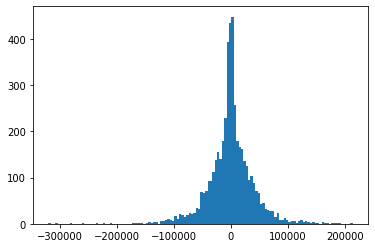

In [23]:
plt.hist(ak.flatten(electrons.px).to_numpy(), bins="auto");

In [24]:
jets = get_collection_4mom(rdf, "AnalysisJets")

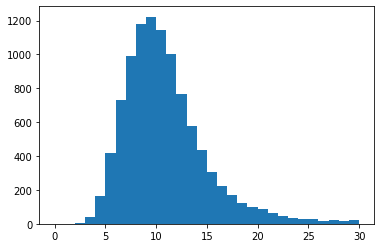

In [25]:
plt.hist(ak.num(jets), bins=30, range=(0, 30));

In [26]:
f = ROOT.TFile.Open(filename)

In [27]:
list(branch.GetName() for branch in f.Get("CollectionTree").GetListOfBranches() if branch.GetName().startswith("AnalysisElectrons"))

['AnalysisElectrons',
 'AnalysisElectronsAux.',
 'AnalysisElectronsAuxDyn.trackParticleLinks',
 'AnalysisElectronsAuxDyn.pt',
 'AnalysisElectronsAuxDyn.eta',
 'AnalysisElectronsAuxDyn.phi',
 'AnalysisElectronsAuxDyn.m',
 'AnalysisElectronsAuxDyn.charge',
 'AnalysisElectronsAuxDyn.ptvarcone30_TightTTVA_pt1000',
 'AnalysisElectronsAuxDyn.ptcone20_TightTTVA_pt1000',
 'AnalysisElectronsAuxDyn.ptvarcone20_TightTTVA_pt1000',
 'AnalysisElectronsAuxDyn.ptvarcone30_TightTTVA_pt500',
 'AnalysisElectronsAuxDyn.ptcone20_TightTTVA_pt500',
 'AnalysisElectronsAuxDyn.DFCommonElectronsLHLoose',
 'AnalysisElectronsAuxDyn.topoetcone20',
 'AnalysisElectronsAuxDyn.ptvarcone20',
 'AnalysisElectronsAuxDyn.truthOrigin',
 'AnalysisElectronsAuxDyn.truthParticleLink',
 'AnalysisElectronsAuxDyn.truthType',
 'AnalysisElectronsAuxDyn.author',
 'AnalysisElectronsAuxDyn.ptvarcone40',
 'AnalysisElectronsAuxDyn.caloClusterLinks',
 'AnalysisElectronsAuxDyn.OQ',
 'AnalysisElectronsAuxDyn.ambiguityLink',
 'AnalysisElectro

In [39]:
rdf5 = rdf.Define("topoetcone20", """
static const SG::AuxElement::ConstAccessor<float> acc("topoetcone20");
std::vector<float> dec;
for (auto electron: AnalysisElectrons) {
    dec.push_back(acc(*electron));
}
return dec;
""")

In [40]:
topoet = vv_rdf_to_ak(rdf5, ["topoetcone20"])

In [41]:
topoet[:10].tolist()

[[],
 [{'topoetcone20': 4930.9033203125}],
 [{'topoetcone20': 1272.5250244140625}],
 [],
 [{'topoetcone20': 1824.3009033203125}],
 [{'topoetcone20': 5487.00390625}],
 [],
 [],
 [],
 [{'topoetcone20': -757.2159423828125}]]

In [42]:
ak_pt[:10].tolist()

[[],
 [4129.17529296875],
 [32111.681640625],
 [],
 [76299.625],
 [5160.49609375],
 [],
 [],
 [],
 [10969.140625]]